In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
column = inspector.get_columns('measurement')
for c in column:
    print(c['name'], c['type'])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

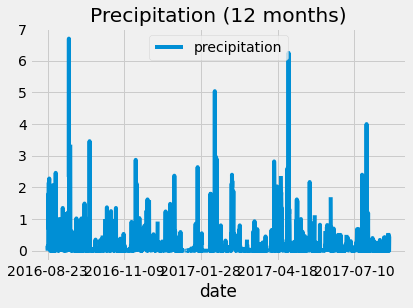

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latestdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latestdate

#extract string from query object
latestdate = list(np.ravel(latestdate))[0]
latestdate

# #convert date string to datetime object
latestdate = dt.datetime.strptime(latestdate, '%Y-%m-%d')
latestdate

# extract year, month, and day as integers
latestYear = int(dt.datetime.strftime(latestdate, '%Y'))
latestMonth = int(dt.datetime.strftime(latestdate, '%m'))
latestDay = int(dt.datetime.strftime(latestdate, '%d'))

# Calculate the date 1 year ago from the last data point in the database
yearbefore = dt.date(latestYear, latestMonth, latestDay) - dt.timedelta(days=365)
yearbefore

#  Perform a query to retrieve the data and precipitation scores
raindata = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date >= yearbefore)
                  .order_by(Measurement.date.asc())
                  .all())

raindata

rain_df = pd.DataFrame(raindata,columns=['date', 'precipitation'])



rain_df.set_index('date', inplace=True)


# Sort the dataframe by date
sorted_rain_df = rain_df.sort_values(by='date', ascending=True)
sorted_rain_df

sorted_rain_df .plot(title="Precipitation (12 months)")
plt.legend(loc='upper center')
plt.show()


In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_rain_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
station_counts = session.query(Station).count()
print(f'Station counts : {station_counts}')

Station counts : 9


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

active_stations

#Find the most active stations.
active_stations_val =active_stations[0] 
active_stations_val

('USC00519281', 2772)

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

observations = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == active_stations_val[0]).all()
      
observations   



[('USC00519281', 54.0, 85.0, 71.66378066378067)]

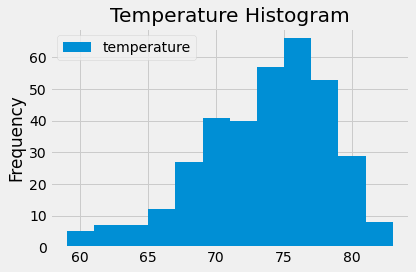

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


high_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
high_temps_station
high_temps_station= high_temps_station[0]
high_temps_station

active_stations_temps = session.query(Measurement.tobs).\
                        filter(Measurement.date>= "2016-08-23").\
                        filter(Measurement.station == "USC00519281").all()
active_stations_temps

temperature_observations = pd.DataFrame(active_stations_temps, columns=['temperature'])

temperature_observations.plot.hist(bins=12, title="Temperature Histogram")
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
